### DataCamp Certification Case Study

Project Brief

Tasty Bytes , an online recipe startup, has hired you as a data scientist. The website features new recipes on the homepage every day. The owner has told you that on days that they feature a popular recipe, traffic increases by as much as 40%. However, it is difficult to predict in advance which recipes will be popular or not.

The data team has collected data from previously published recipes. The owner wants to know whether you can use this information to predict whether a recipe will be popular (or in other words, receive a high score). She is especially interested in preventing unpopular (low-scoring) recipes from appearing on the homepage. She estimates that of all unpopular recipes, they currently correctly categorize 75% of them as being unpopular. She wants to know how your solution would compare to this guessing approach.

You will need to present your findings in two formats:

You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why.
You will then need to share your findings with the owner in a 10 minute presentation. The owner has no data science background but is familiar with basic data related terminology.
The data you will use for this analysis can be accessed here: "data/recipes.csv"

In [1]:
# Import Library
import numpy
import copy
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from collections import Counter
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#**2. DATA LOADING AND OVERVIEW**

In [2]:
dataFrame = read_csv('recipes.csv')

In [3]:
dataFrame.shape

(43092, 10)

In [4]:
dataFrame.head()

,RecipeId,Name,RecipeCategory,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
0,46085,Crock Pot Baked Potato Soup,One Dish Meal,699.8,137.3,46.1,1.4,20.9,6.0,1.0
1,93832,Frittata Di Spaghetti (spaghetti Frittata),Breakfast,297.1,191.8,11.7,0.7,12.2,8.0,1.0
2,36034,Berries With Italian Cream,Dessert,131.9,23.3,10.3,4.4,9.1,6.0,0.0
3,329988,Pork Tenderloin Medallions With Fresh Figs,< 15 Mins,203.0,74.8,1.5,0.6,23.3,4.0,1.0
4,59886,Kaseropita (Tiropita Using Kaseri Cheese),Savory Pies,261.6,103.6,20.9,0.2,6.7,15.0,1.0


In [5]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43092 entries, 0 to 43091
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RecipeId             43092 non-null  int64  
 1   Name                 43092 non-null  object 
 2   RecipeCategory       43052 non-null  object 
 3   Calories             43092 non-null  float64
 4   CholesterolContent   43092 non-null  float64
 5   CarbohydrateContent  43092 non-null  float64
 6   SugarContent         43092 non-null  float64
 7   ProteinContent       43092 non-null  float64
 8   RecipeServings       43092 non-null  float64
 9   HighScore            43092 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 3.3+ MB


In [6]:
dataFrame.describe()

,RecipeId,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
count,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000
mean,224707.928154,353.297587,69.475757,32.844187,12.206600,15.773125,9.517521,0.645735
std,141980.914350,405.065683,112.422309,46.428258,28.304371,21.588594,224.022873,0.478296
min,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,102616.750000,164.800000,4.500000,11.600000,2.200000,3.400000,4.000000,0.000000
50%,212333.000000,284.100000,40.700000,25.400000,5.500000,8.800000,6.000000,1.000000
75%,336736.250000,446.725000,95.900000,43.400000,14.100000,24.300000,8.000000,1.000000
max,540876.000000,30933.400000,9167.200000,3564.400000,2566.800000,1420.800000,32767.000000,1.000000


In [7]:
dataFrame.RecipeServings.describe()

count    43092.000000
mean         9.517521
std        224.022873
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max      32767.000000
Name: RecipeServings, dtype: float64

In [8]:
dataFrame.RecipeCategory.value_counts().sort_values(ascending = False).head(20)

Dessert           4211
Lunch/Snacks      3271
One Dish Meal     2895
Vegetable         2497
Breakfast         1969
Beverages         1803
Chicken           1392
Chicken Breast    1383
Pork              1185
Meat              1140
Potato            1082
Breads             897
Quick Breads       828
Cheese             739
Sauces             649
Pie                621
< 60 Mins          599
< 30 Mins          571
Bar Cookie         546
Stew               481
Name: RecipeCategory, dtype: int64

In [9]:
top_15 = [ x for x in dataFrame.RecipeCategory.value_counts().sort_values(ascending = False).head(15).index]
top_15

['Dessert',
 'Lunch/Snacks',
 'One Dish Meal',
 'Vegetable',
 'Breakfast',
 'Beverages',
 'Chicken',
 'Chicken Breast',
 'Pork',
 'Meat',
 'Potato',
 'Breads',
 'Quick Breads',
 'Cheese',
 'Sauces']

In [10]:
for label in top_15:
    dataFrame[label] = numpy.where(dataFrame['RecipeCategory'] == label, 1, 0)
dataFrame[['RecipeCategory'] + top_15].head(10)

,RecipeCategory,Dessert,Lunch/Snacks,One Dish Meal,Vegetable,Breakfast,Beverages,Chicken,Chicken Breast,Pork,Meat,Potato,Breads,Quick Breads,Cheese,Sauces
0,One Dish Meal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Breakfast,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Dessert,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,< 15 Mins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Savory Pies,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Smoothies,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Lamb/Sheep,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Vegetable,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,Beverages,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,Dessert,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
def one_hot_top_x(df, variable, top_x_labels):
    for label in top_x_labels:
        df[variable+'_'+label] = numpy.where(dataFrame[variable] == label, 1, 0)

one_hot_top_x(dataFrame, 'RecipeCategory', top_15)
dataFrame.head()

,RecipeId,Name,RecipeCategory,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore,...,RecipeCategory_Beverages,RecipeCategory_Chicken,RecipeCategory_Chicken Breast,RecipeCategory_Pork,RecipeCategory_Meat,RecipeCategory_Potato,RecipeCategory_Breads,RecipeCategory_Quick Breads,RecipeCategory_Cheese,RecipeCategory_Sauces
0,46085,Crock Pot Baked Potato Soup,One Dish Meal,699.8,137.3,46.1,1.4,20.9,6.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,93832,Frittata Di Spaghetti (spaghetti Frittata),Breakfast,297.1,191.8,11.7,0.7,12.2,8.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,36034,Berries With Italian Cream,Dessert,131.9,23.3,10.3,4.4,9.1,6.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,329988,Pork Tenderloin Medallions With Fresh Figs,< 15 Mins,203.0,74.8,1.5,0.6,23.3,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,59886,Kaseropita (Tiropita Using Kaseri Cheese),Savory Pies,261.6,103.6,20.9,0.2,6.7,15.0,1.0,...,0,0,0,0,0,0,0,0,0,0


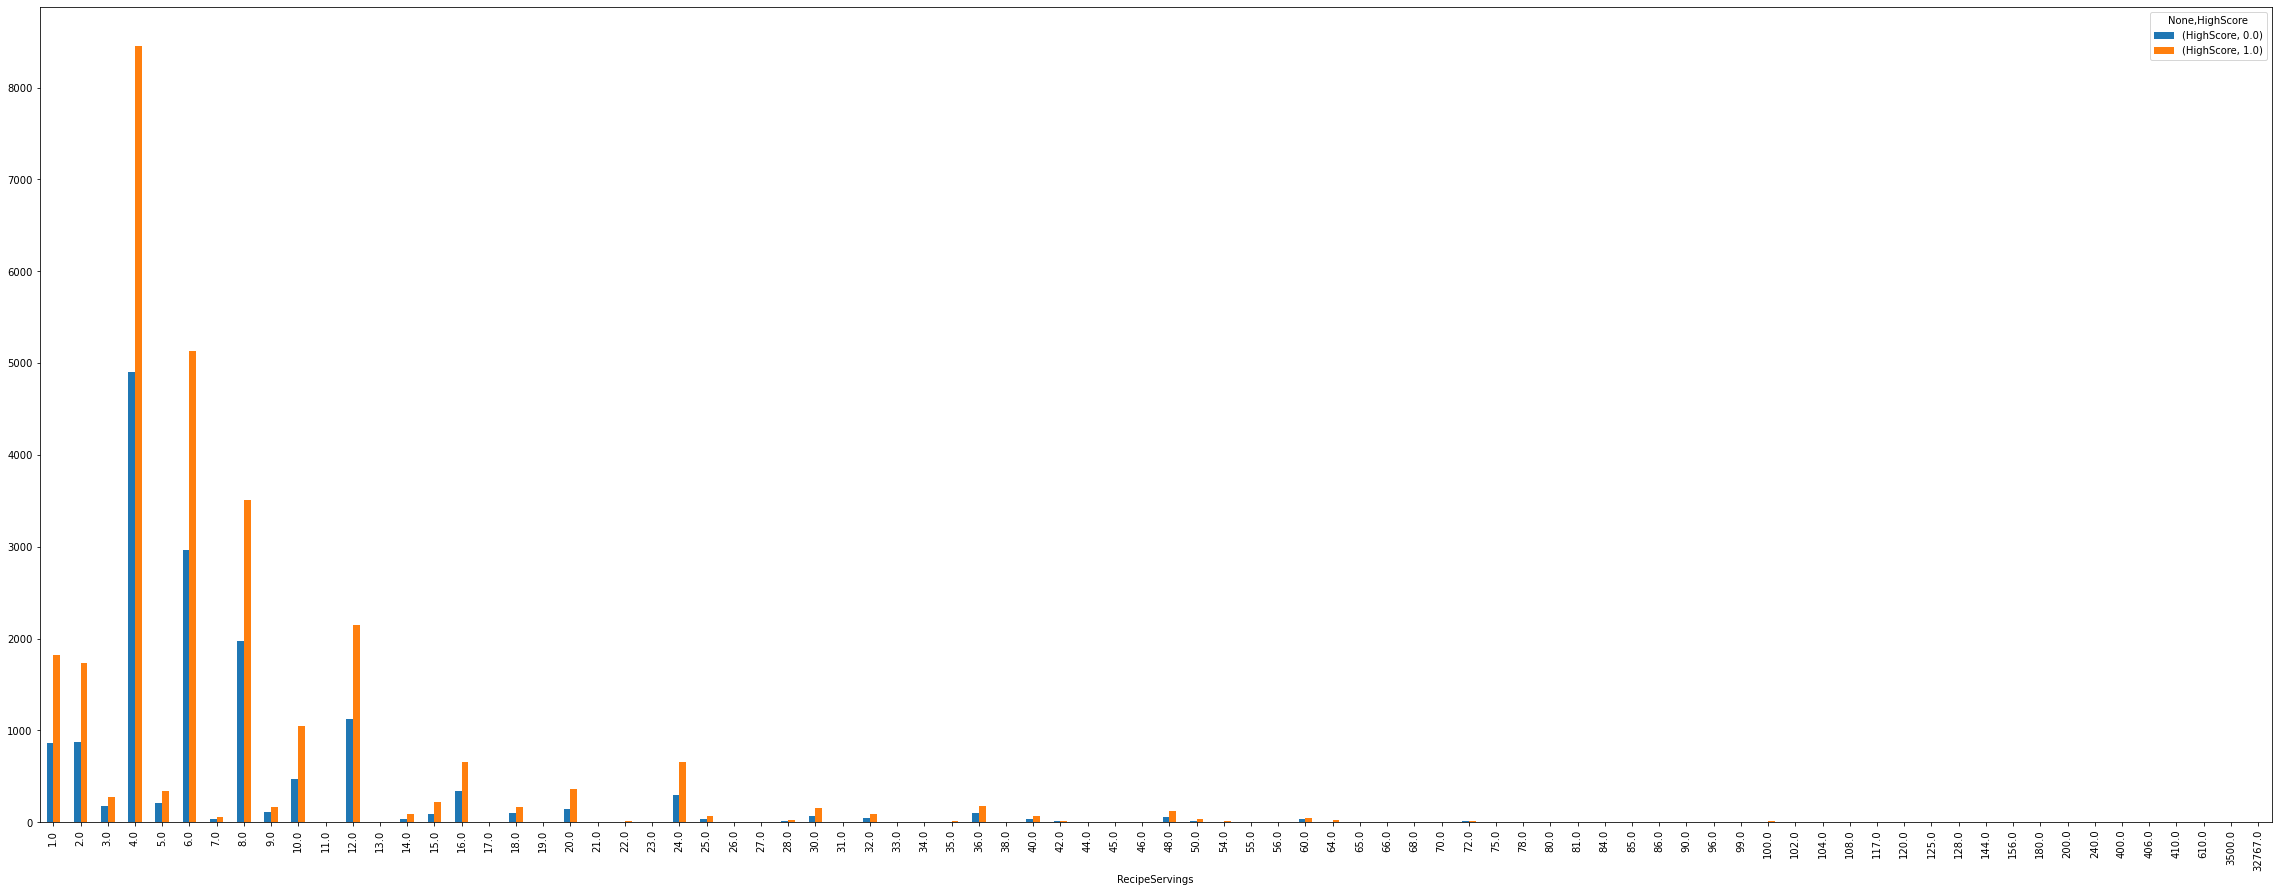

In [12]:
dataFrame.groupby(by=['RecipeServings', 'HighScore']).agg({'HighScore': 'count'}).unstack().plot(kind='bar', figsize=(40,15));

**I think id column won't effect to results, so i will delete it!!!**

In [13]:
dataFrame = dataFrame.drop(['RecipeId', 'Name', 'RecipeCategory' ], axis=1)
dataFrame.head()

,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore,Dessert,Lunch/Snacks,One Dish Meal,...,RecipeCategory_Beverages,RecipeCategory_Chicken,RecipeCategory_Chicken Breast,RecipeCategory_Pork,RecipeCategory_Meat,RecipeCategory_Potato,RecipeCategory_Breads,RecipeCategory_Quick Breads,RecipeCategory_Cheese,RecipeCategory_Sauces
0,699.8,137.3,46.1,1.4,20.9,6.0,1.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,297.1,191.8,11.7,0.7,12.2,8.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,131.9,23.3,10.3,4.4,9.1,6.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,203.0,74.8,1.5,0.6,23.3,4.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,261.6,103.6,20.9,0.2,6.7,15.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43092 entries, 0 to 43091
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Calories                       43092 non-null  float64
 1   CholesterolContent             43092 non-null  float64
 2   CarbohydrateContent            43092 non-null  float64
 3   SugarContent                   43092 non-null  float64
 4   ProteinContent                 43092 non-null  float64
 5   RecipeServings                 43092 non-null  float64
 6   HighScore                      43092 non-null  float64
 7   Dessert                        43092 non-null  int64  
 8   Lunch/Snacks                   43092 non-null  int64  
 9   One Dish Meal                  43092 non-null  int64  
 10  Vegetable                      43092 non-null  int64  
 11  Breakfast                      43092 non-null  int64  
 12  Beverages                      43092 non-null 

In [15]:
dataFrame["HighScore"] = dataFrame["HighScore"].apply(lambda x: 1 if x == 1.0 else 0)
dataFrame

,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore,Dessert,Lunch/Snacks,One Dish Meal,...,RecipeCategory_Beverages,RecipeCategory_Chicken,RecipeCategory_Chicken Breast,RecipeCategory_Pork,RecipeCategory_Meat,RecipeCategory_Potato,RecipeCategory_Breads,RecipeCategory_Quick Breads,RecipeCategory_Cheese,RecipeCategory_Sauces
0,699.8,137.3,46.1,1.4,20.9,6.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,297.1,191.8,11.7,0.7,12.2,8.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,131.9,23.3,10.3,4.4,9.1,6.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,203.0,74.8,1.5,0.6,23.3,4.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,261.6,103.6,20.9,0.2,6.7,15.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,281.5,111.3,13.2,11.1,25.3,6.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
43088,697.2,242.1,3.8,1.9,72.9,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43089,94.5,0.0,22.7,19.1,2.0,14.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43090,207.1,72.6,20.1,12.7,24.9,4.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [16]:
dataFrame['Calo_Serving'] = dataFrame['Calories']/dataFrame['RecipeServings']
dataFrame

,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore,Dessert,Lunch/Snacks,One Dish Meal,...,RecipeCategory_Chicken,RecipeCategory_Chicken Breast,RecipeCategory_Pork,RecipeCategory_Meat,RecipeCategory_Potato,RecipeCategory_Breads,RecipeCategory_Quick Breads,RecipeCategory_Cheese,RecipeCategory_Sauces,Calo_Serving
0,699.8,137.3,46.1,1.4,20.9,6.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,116.633333
1,297.1,191.8,11.7,0.7,12.2,8.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,37.137500
2,131.9,23.3,10.3,4.4,9.1,6.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,21.983333
3,203.0,74.8,1.5,0.6,23.3,4.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,50.750000
4,261.6,103.6,20.9,0.2,6.7,15.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,17.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,281.5,111.3,13.2,11.1,25.3,6.0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,46.916667
43088,697.2,242.1,3.8,1.9,72.9,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,174.300000
43089,94.5,0.0,22.7,19.1,2.0,14.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6.750000
43090,207.1,72.6,20.1,12.7,24.9,4.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,51.775000


In [17]:
dataFrame['Cholesterol_Serving'] = dataFrame['CholesterolContent']/dataFrame['RecipeServings']
dataFrame

,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore,Dessert,Lunch/Snacks,One Dish Meal,...,RecipeCategory_Chicken Breast,RecipeCategory_Pork,RecipeCategory_Meat,RecipeCategory_Potato,RecipeCategory_Breads,RecipeCategory_Quick Breads,RecipeCategory_Cheese,RecipeCategory_Sauces,Calo_Serving,Cholesterol_Serving
0,699.8,137.3,46.1,1.4,20.9,6.0,1,0,0,1,...,0,0,0,0,0,0,0,0,116.633333,22.883333
1,297.1,191.8,11.7,0.7,12.2,8.0,1,0,0,0,...,0,0,0,0,0,0,0,0,37.137500,23.975000
2,131.9,23.3,10.3,4.4,9.1,6.0,0,1,0,0,...,0,0,0,0,0,0,0,0,21.983333,3.883333
3,203.0,74.8,1.5,0.6,23.3,4.0,1,0,0,0,...,0,0,0,0,0,0,0,0,50.750000,18.700000
4,261.6,103.6,20.9,0.2,6.7,15.0,1,0,0,0,...,0,0,0,0,0,0,0,0,17.440000,6.906667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,281.5,111.3,13.2,11.1,25.3,6.0,1,0,0,0,...,0,0,1,0,0,0,0,0,46.916667,18.550000
43088,697.2,242.1,3.8,1.9,72.9,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,174.300000,60.525000
43089,94.5,0.0,22.7,19.1,2.0,14.0,1,0,0,0,...,0,0,0,0,0,0,0,0,6.750000,0.000000
43090,207.1,72.6,20.1,12.7,24.9,4.0,1,0,0,0,...,1,0,0,0,0,0,0,0,51.775000,18.150000


In [18]:
dataFrame['Carbohydrate_Serving'] = dataFrame['CarbohydrateContent']/dataFrame['RecipeServings']
dataFrame

,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore,Dessert,Lunch/Snacks,One Dish Meal,...,RecipeCategory_Pork,RecipeCategory_Meat,RecipeCategory_Potato,RecipeCategory_Breads,RecipeCategory_Quick Breads,RecipeCategory_Cheese,RecipeCategory_Sauces,Calo_Serving,Cholesterol_Serving,Carbohydrate_Serving
0,699.8,137.3,46.1,1.4,20.9,6.0,1,0,0,1,...,0,0,0,0,0,0,0,116.633333,22.883333,7.683333
1,297.1,191.8,11.7,0.7,12.2,8.0,1,0,0,0,...,0,0,0,0,0,0,0,37.137500,23.975000,1.462500
2,131.9,23.3,10.3,4.4,9.1,6.0,0,1,0,0,...,0,0,0,0,0,0,0,21.983333,3.883333,1.716667
3,203.0,74.8,1.5,0.6,23.3,4.0,1,0,0,0,...,0,0,0,0,0,0,0,50.750000,18.700000,0.375000
4,261.6,103.6,20.9,0.2,6.7,15.0,1,0,0,0,...,0,0,0,0,0,0,0,17.440000,6.906667,1.393333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,281.5,111.3,13.2,11.1,25.3,6.0,1,0,0,0,...,0,1,0,0,0,0,0,46.916667,18.550000,2.200000
43088,697.2,242.1,3.8,1.9,72.9,4.0,0,0,0,0,...,0,0,0,0,0,0,0,174.300000,60.525000,0.950000
43089,94.5,0.0,22.7,19.1,2.0,14.0,1,0,0,0,...,0,0,0,0,0,0,0,6.750000,0.000000,1.621429
43090,207.1,72.6,20.1,12.7,24.9,4.0,1,0,0,0,...,0,0,0,0,0,0,0,51.775000,18.150000,5.025000


In [19]:
dataFrame['Sugar_Serving'] = dataFrame['SugarContent']/dataFrame['RecipeServings']
dataFrame

,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore,Dessert,Lunch/Snacks,One Dish Meal,...,RecipeCategory_Meat,RecipeCategory_Potato,RecipeCategory_Breads,RecipeCategory_Quick Breads,RecipeCategory_Cheese,RecipeCategory_Sauces,Calo_Serving,Cholesterol_Serving,Carbohydrate_Serving,Sugar_Serving
0,699.8,137.3,46.1,1.4,20.9,6.0,1,0,0,1,...,0,0,0,0,0,0,116.633333,22.883333,7.683333,0.233333
1,297.1,191.8,11.7,0.7,12.2,8.0,1,0,0,0,...,0,0,0,0,0,0,37.137500,23.975000,1.462500,0.087500
2,131.9,23.3,10.3,4.4,9.1,6.0,0,1,0,0,...,0,0,0,0,0,0,21.983333,3.883333,1.716667,0.733333
3,203.0,74.8,1.5,0.6,23.3,4.0,1,0,0,0,...,0,0,0,0,0,0,50.750000,18.700000,0.375000,0.150000
4,261.6,103.6,20.9,0.2,6.7,15.0,1,0,0,0,...,0,0,0,0,0,0,17.440000,6.906667,1.393333,0.013333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,281.5,111.3,13.2,11.1,25.3,6.0,1,0,0,0,...,1,0,0,0,0,0,46.916667,18.550000,2.200000,1.850000
43088,697.2,242.1,3.8,1.9,72.9,4.0,0,0,0,0,...,0,0,0,0,0,0,174.300000,60.525000,0.950000,0.475000
43089,94.5,0.0,22.7,19.1,2.0,14.0,1,0,0,0,...,0,0,0,0,0,0,6.750000,0.000000,1.621429,1.364286
43090,207.1,72.6,20.1,12.7,24.9,4.0,1,0,0,0,...,0,0,0,0,0,0,51.775000,18.150000,5.025000,3.175000


In [20]:
dataFrame['Protein_Serving'] = dataFrame['ProteinContent']/dataFrame['RecipeServings']
dataFrame

,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore,Dessert,Lunch/Snacks,One Dish Meal,...,RecipeCategory_Potato,RecipeCategory_Breads,RecipeCategory_Quick Breads,RecipeCategory_Cheese,RecipeCategory_Sauces,Calo_Serving,Cholesterol_Serving,Carbohydrate_Serving,Sugar_Serving,Protein_Serving
0,699.8,137.3,46.1,1.4,20.9,6.0,1,0,0,1,...,0,0,0,0,0,116.633333,22.883333,7.683333,0.233333,3.483333
1,297.1,191.8,11.7,0.7,12.2,8.0,1,0,0,0,...,0,0,0,0,0,37.137500,23.975000,1.462500,0.087500,1.525000
2,131.9,23.3,10.3,4.4,9.1,6.0,0,1,0,0,...,0,0,0,0,0,21.983333,3.883333,1.716667,0.733333,1.516667
3,203.0,74.8,1.5,0.6,23.3,4.0,1,0,0,0,...,0,0,0,0,0,50.750000,18.700000,0.375000,0.150000,5.825000
4,261.6,103.6,20.9,0.2,6.7,15.0,1,0,0,0,...,0,0,0,0,0,17.440000,6.906667,1.393333,0.013333,0.446667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,281.5,111.3,13.2,11.1,25.3,6.0,1,0,0,0,...,0,0,0,0,0,46.916667,18.550000,2.200000,1.850000,4.216667
43088,697.2,242.1,3.8,1.9,72.9,4.0,0,0,0,0,...,0,0,0,0,0,174.300000,60.525000,0.950000,0.475000,18.225000
43089,94.5,0.0,22.7,19.1,2.0,14.0,1,0,0,0,...,0,0,0,0,0,6.750000,0.000000,1.621429,1.364286,0.142857
43090,207.1,72.6,20.1,12.7,24.9,4.0,1,0,0,0,...,0,0,0,0,0,51.775000,18.150000,5.025000,3.175000,6.225000


In [21]:
dataFrame.describe()

,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore,Dessert,Lunch/Snacks,One Dish Meal,...,RecipeCategory_Potato,RecipeCategory_Breads,RecipeCategory_Quick Breads,RecipeCategory_Cheese,RecipeCategory_Sauces,Calo_Serving,Cholesterol_Serving,Carbohydrate_Serving,Sugar_Serving,Protein_Serving
count,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,...,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000
mean,353.297587,69.475757,32.844187,12.206600,15.773125,9.517521,0.645735,0.097721,0.075907,0.067182,...,0.025109,0.020816,0.019215,0.017149,0.015061,96.181402,18.782301,9.011947,3.560549,4.171104
std,405.065683,112.422309,46.428258,28.304371,21.588594,224.022873,0.478296,0.296941,0.264853,0.250340,...,0.156458,0.142769,0.137281,0.129829,0.121796,290.282816,66.917921,34.549490,24.244578,13.024165
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,164.800000,4.500000,11.600000,2.200000,3.400000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,22.777083,0.425000,1.675000,0.350000,0.425000
50%,284.100000,40.700000,25.400000,5.500000,8.800000,6.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,51.533333,6.000000,4.033333,0.950000,1.675000
75%,446.725000,95.900000,43.400000,14.100000,24.300000,8.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,100.954167,19.300000,8.616667,2.487500,5.325000
max,30933.400000,9167.200000,3564.400000,2566.800000,1420.800000,32767.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,25248.700000,4251.100000,2700.900000,2566.800000,1420.800000


In [22]:
dataFrame = dataFrame.drop(['Calories','CholesterolContent', 'CarbohydrateContent', 'SugarContent', 'ProteinContent'], axis=1)
dataFrame.head()

,RecipeServings,HighScore,Dessert,Lunch/Snacks,One Dish Meal,Vegetable,Breakfast,Beverages,Chicken,Chicken Breast,...,RecipeCategory_Potato,RecipeCategory_Breads,RecipeCategory_Quick Breads,RecipeCategory_Cheese,RecipeCategory_Sauces,Calo_Serving,Cholesterol_Serving,Carbohydrate_Serving,Sugar_Serving,Protein_Serving
0,6.0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,116.633333,22.883333,7.683333,0.233333,3.483333
1,8.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,37.137500,23.975000,1.462500,0.087500,1.525000
2,6.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,21.983333,3.883333,1.716667,0.733333,1.516667
3,4.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,50.750000,18.700000,0.375000,0.150000,5.825000
4,15.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,17.440000,6.906667,1.393333,0.013333,0.446667


<function matplotlib.pyplot.show(close=None, block=None)>

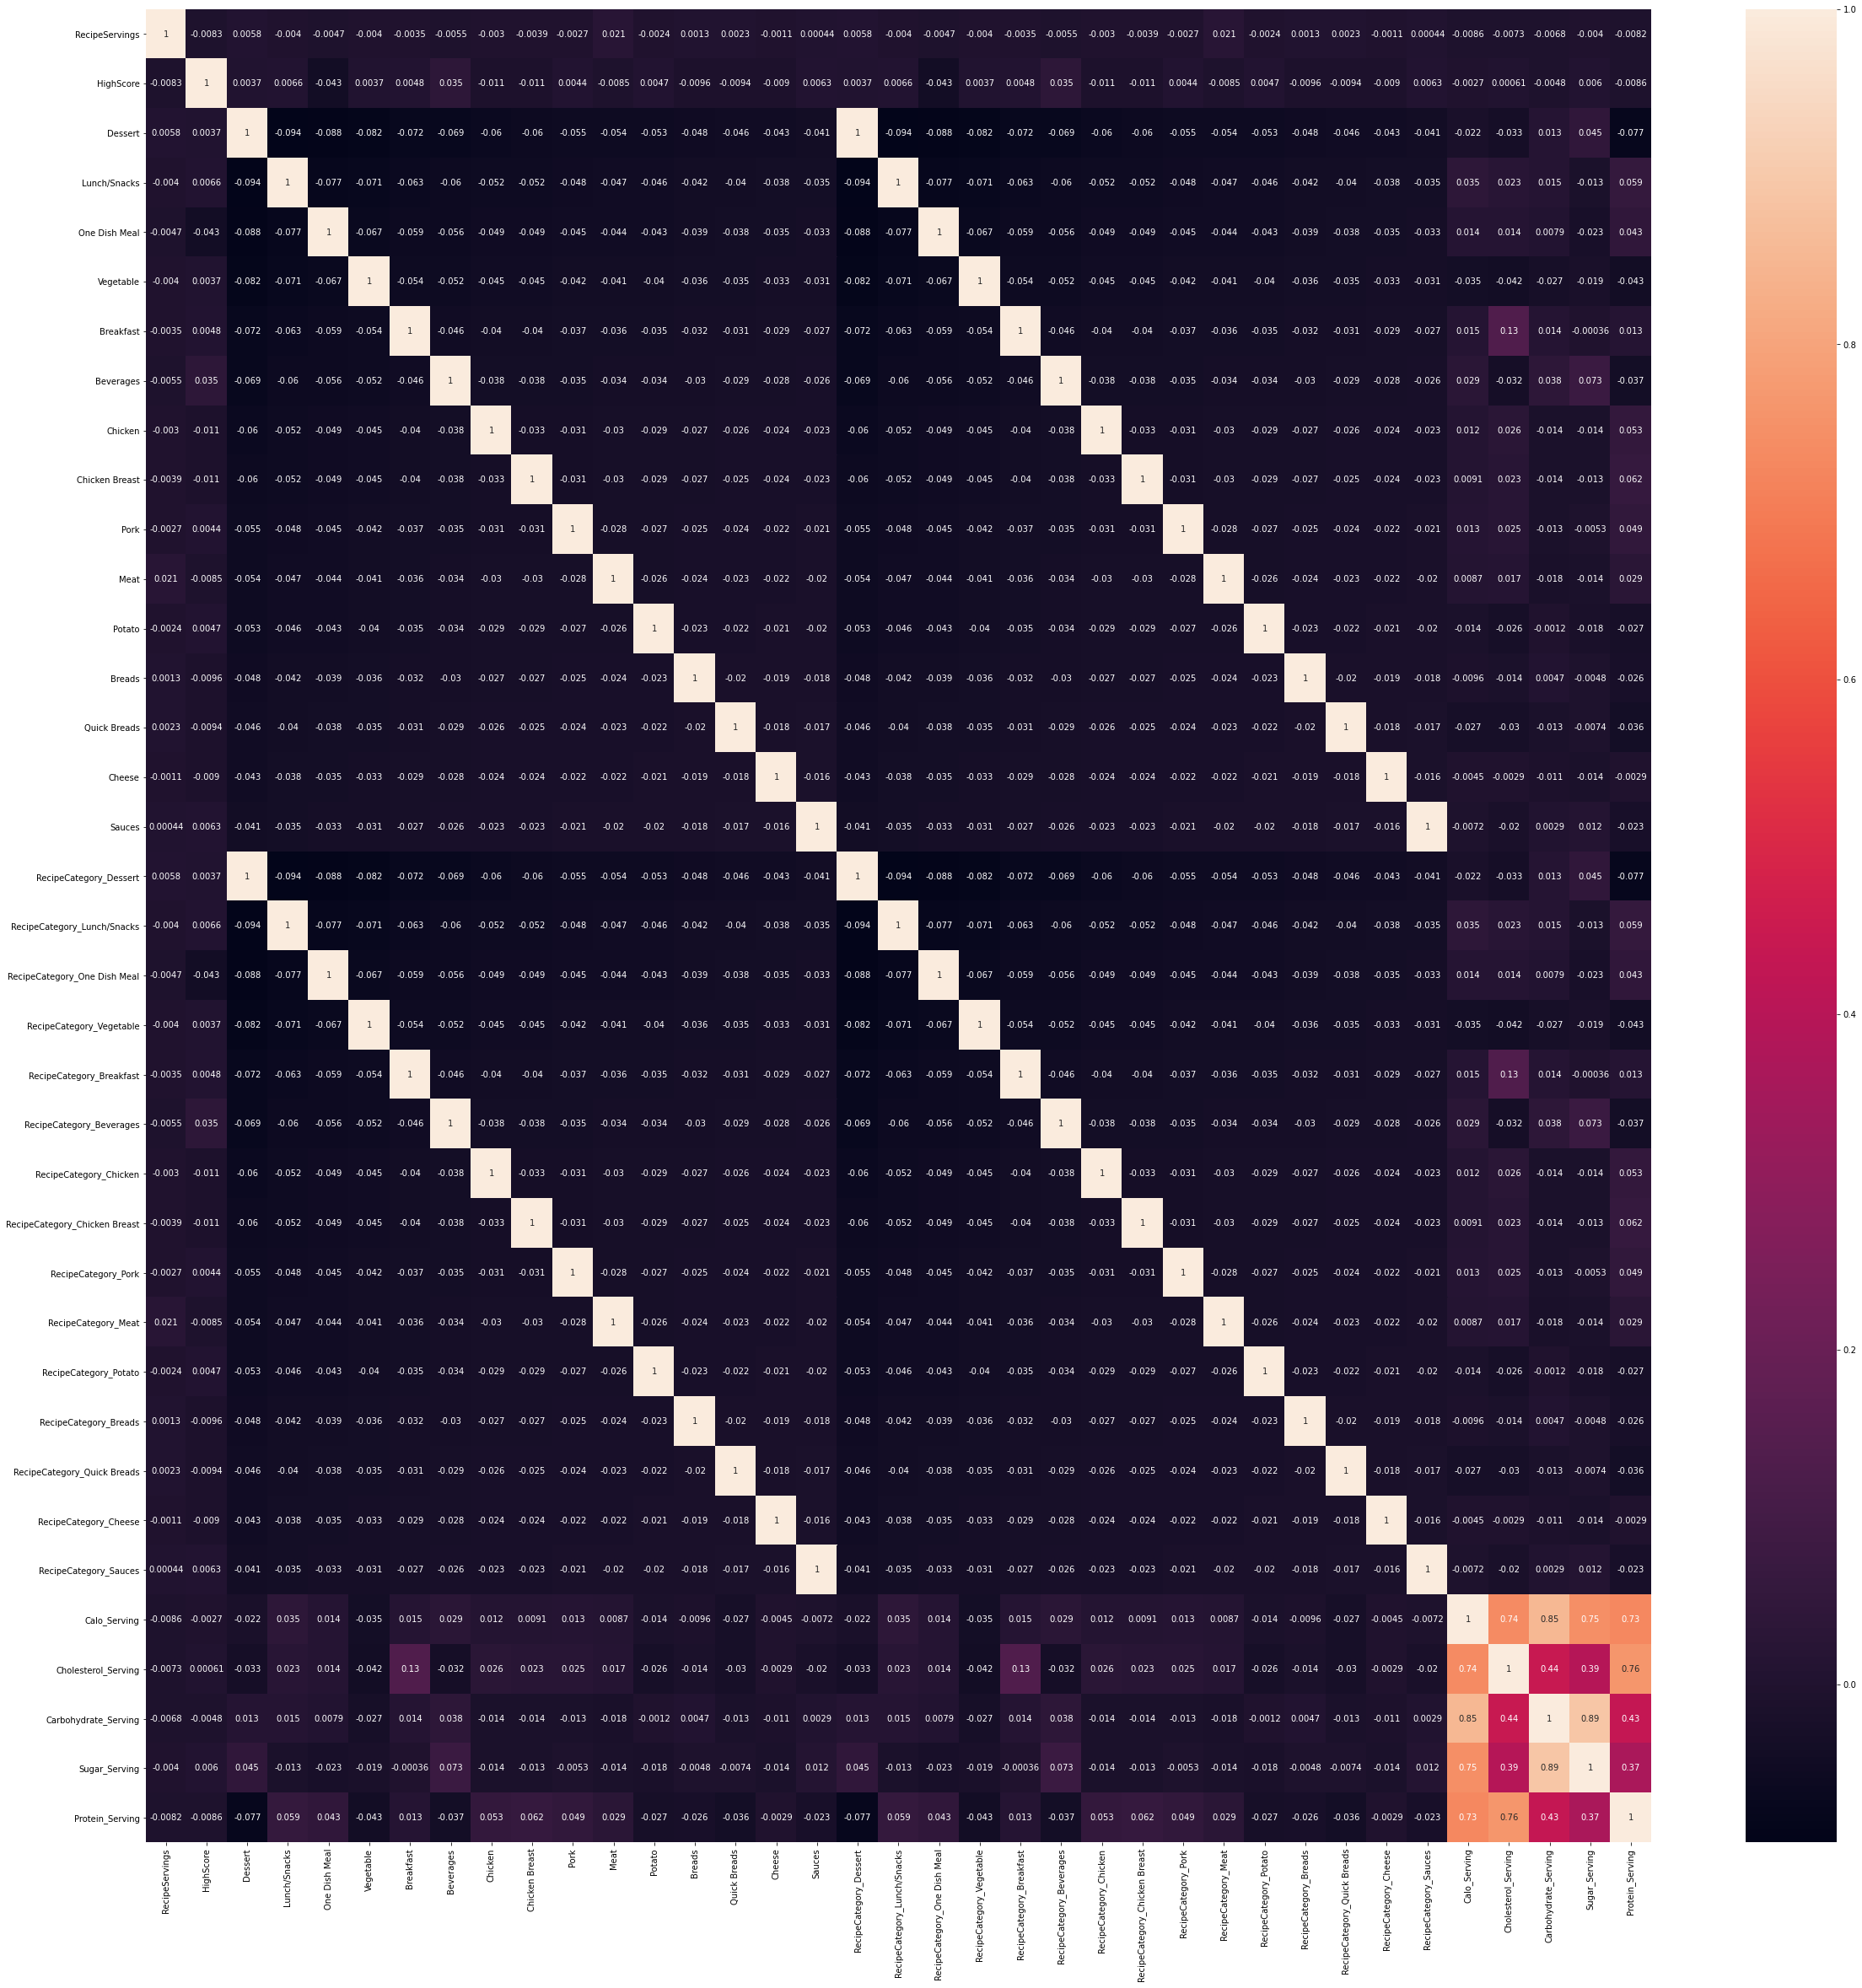

In [23]:
# Correlation

plt.figure(figsize=(40, 40))
sns.heatmap(dataFrame.corr(), annot = True)
plt.show

In [24]:
dataFrame.corr()['HighScore'].sort_values()

One Dish Meal                   -0.042717
RecipeCategory_One Dish Meal    -0.042717
RecipeCategory_Chicken Breast   -0.011301
Chicken Breast                  -0.011301
RecipeCategory_Chicken          -0.010665
Chicken                         -0.010665
RecipeCategory_Breads           -0.009592
Breads                          -0.009592
RecipeCategory_Quick Breads     -0.009425
Quick Breads                    -0.009425
RecipeCategory_Cheese           -0.009043
Cheese                          -0.009043
Protein_Serving                 -0.008617
RecipeCategory_Meat             -0.008507
Meat                            -0.008507
RecipeServings                  -0.008314
Carbohydrate_Serving            -0.004836
Calo_Serving                    -0.002737
Cholesterol_Serving              0.000608
Vegetable                        0.003655
RecipeCategory_Vegetable         0.003655
RecipeCategory_Dessert           0.003727
Dessert                          0.003727
Pork                             0

array([[<AxesSubplot:title={'center':'RecipeServings'}>,
        <AxesSubplot:title={'center':'HighScore'}>,
        <AxesSubplot:title={'center':'Dessert'}>,
        <AxesSubplot:title={'center':'Lunch/Snacks'}>,
        <AxesSubplot:title={'center':'One Dish Meal'}>,
        <AxesSubplot:title={'center':'Vegetable'}>],
       [<AxesSubplot:title={'center':'Breakfast'}>,
        <AxesSubplot:title={'center':'Beverages'}>,
        <AxesSubplot:title={'center':'Chicken'}>,
        <AxesSubplot:title={'center':'Chicken Breast'}>,
        <AxesSubplot:title={'center':'Pork'}>,
        <AxesSubplot:title={'center':'Meat'}>],
       [<AxesSubplot:title={'center':'Potato'}>,
        <AxesSubplot:title={'center':'Breads'}>,
        <AxesSubplot:title={'center':'Quick Breads'}>,
        <AxesSubplot:title={'center':'Cheese'}>,
        <AxesSubplot:title={'center':'Sauces'}>,
        <AxesSubplot:title={'center':'RecipeCategory_Dessert'}>],
       [<AxesSubplot:title={'center':'RecipeCategory_L

<Figure size 2160x2160 with 0 Axes>

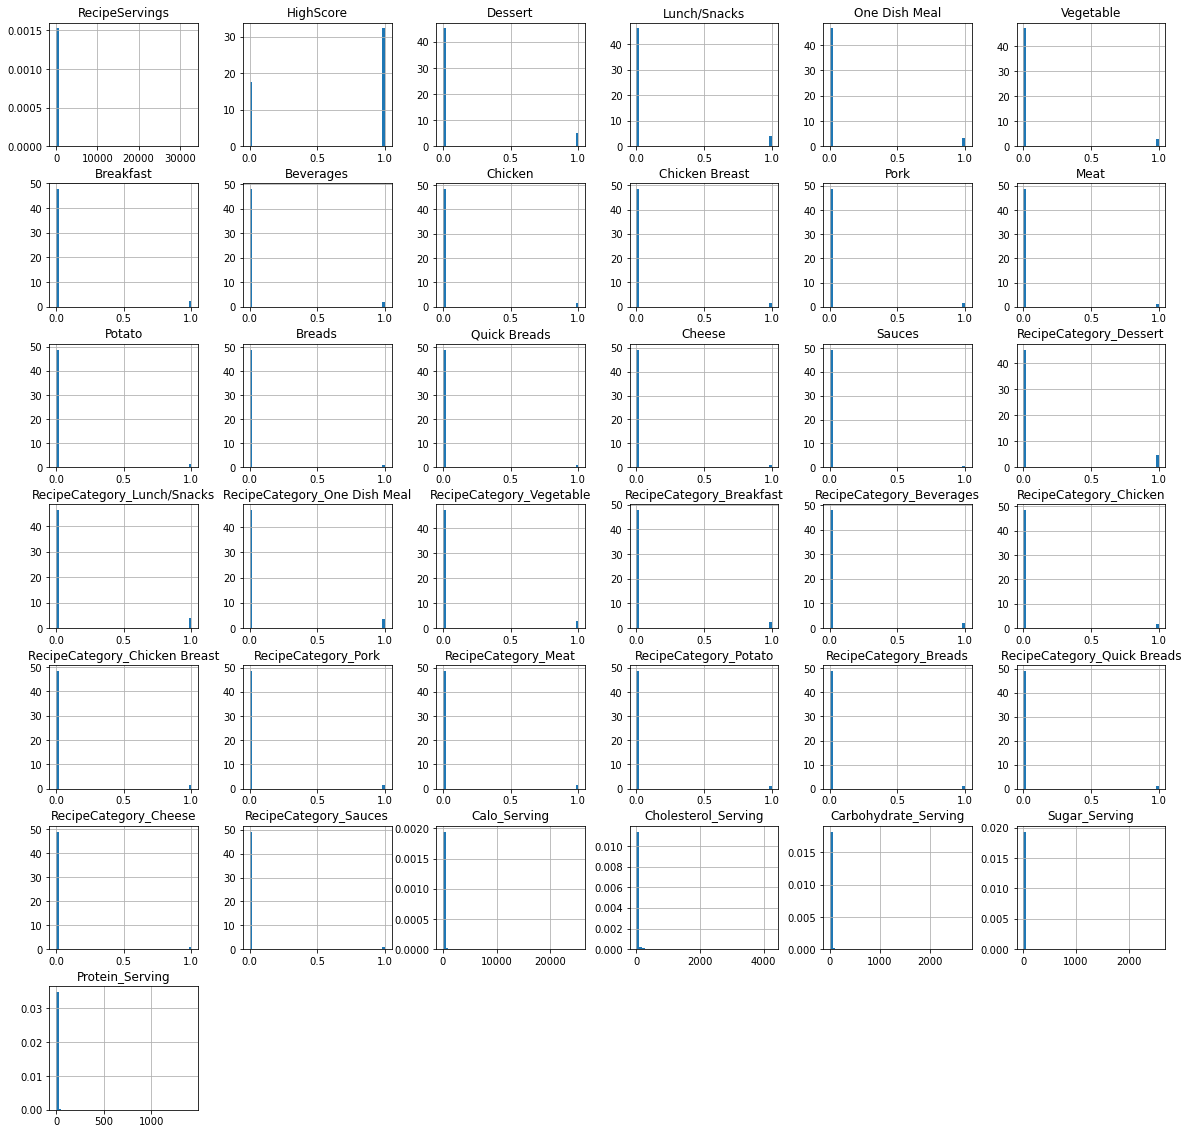

In [25]:
# Histogram
plt.figure(figsize = (30, 30))
dataFrame.hist(bins = 50, figsize = (20, 20), density = 1)

In [26]:
dataFrame.shape

(43092, 37)

In [27]:
X = dataFrame.drop(["HighScore"], axis = 1)
Y = dataFrame["HighScore"]
Y.value_counts()

1    27826
0    15266
Name: HighScore, dtype: int64

In [28]:
X

,RecipeServings,Dessert,Lunch/Snacks,One Dish Meal,Vegetable,Breakfast,Beverages,Chicken,Chicken Breast,Pork,...,RecipeCategory_Potato,RecipeCategory_Breads,RecipeCategory_Quick Breads,RecipeCategory_Cheese,RecipeCategory_Sauces,Calo_Serving,Cholesterol_Serving,Carbohydrate_Serving,Sugar_Serving,Protein_Serving
0,6.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,116.633333,22.883333,7.683333,0.233333,3.483333
1,8.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,37.137500,23.975000,1.462500,0.087500,1.525000
2,6.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,21.983333,3.883333,1.716667,0.733333,1.516667
3,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,50.750000,18.700000,0.375000,0.150000,5.825000
4,15.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,17.440000,6.906667,1.393333,0.013333,0.446667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,6.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,46.916667,18.550000,2.200000,1.850000,4.216667
43088,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,174.300000,60.525000,0.950000,0.475000,18.225000
43089,14.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6.750000,0.000000,1.621429,1.364286,0.142857
43090,4.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,51.775000,18.150000,5.025000,3.175000,6.225000


In [29]:
Y

0        1
1        1
2        0
3        1
4        1
        ..
43087    1
43088    0
43089    1
43090    1
43091    1
Name: HighScore, Length: 43092, dtype: int64

In [30]:
dataFrame.shape

(43092, 37)

In [31]:
# Divide dataFrame into 2 datasets: train and validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((34473, 36), (8619, 36))

Accuracy is:  0.6447383687202691
              precision    recall  f1-score   support

           0       0.50      0.00      0.00      3062
           1       0.64      1.00      0.78      5557

    accuracy                           0.64      8619
   macro avg       0.57      0.50      0.39      8619
weighted avg       0.59      0.64      0.51      8619



/Users/hothanhphong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


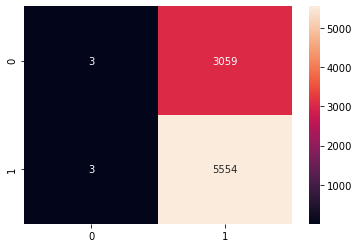

In [32]:
lr = LogisticRegression(solver='lbfgs', penalty ='l2')
lr.fit(X_train, Y_train)
lr.score(X_test, Y_test)

y_pred = lr.predict(X_test)
ac = accuracy_score(Y_test,y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");
print(classification_report(Y_test, y_pred))

Accuracy is:  0.5974010906137603
              precision    recall  f1-score   support

           0       0.39      0.24      0.30      3062
           1       0.65      0.80      0.72      5557

    accuracy                           0.60      8619
   macro avg       0.52      0.52      0.51      8619
weighted avg       0.56      0.60      0.57      8619



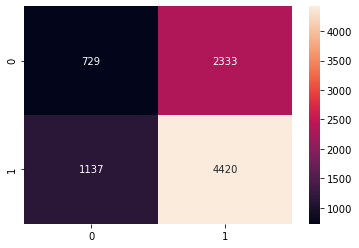

In [33]:
#Create a Gaussian Classifier
nb = GaussianNB()

# Train the model using the training sets 
nb.fit(X_train, Y_train)

#Predict Score 
y_pred = nb.predict(X_test)
ac = accuracy_score(Y_test, y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");
print(classification_report(Y_test, y_pred))

Accuracy is:  0.6137602970182156
              precision    recall  f1-score   support

           0       0.39      0.15      0.22      3062
           1       0.65      0.87      0.74      5557

    accuracy                           0.61      8619
   macro avg       0.52      0.51      0.48      8619
weighted avg       0.56      0.61      0.56      8619



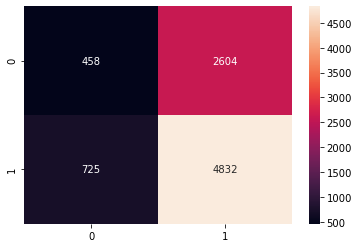

In [34]:
rf = RandomForestClassifier(random_state=42)
# Train the model using the training sets 
rf.fit(X_train, Y_train)

#Predict Score 
y_pred = rf.predict(X_test)
ac = accuracy_score(Y_test, y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");
print(classification_report(Y_test, y_pred))

Accuracy is:  0.9984915731151915
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12204
           1       1.00      1.00      1.00     22269

    accuracy                           1.00     34473
   macro avg       1.00      1.00      1.00     34473
weighted avg       1.00      1.00      1.00     34473



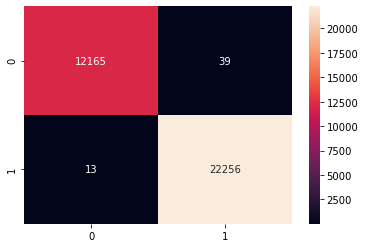

In [35]:
#Predict Score 
y_pred_train = rf.predict(X_train)
ac_train = accuracy_score(Y_train, y_pred_train)
print('Accuracy is: ',ac_train)
cm1 = confusion_matrix(Y_train, y_pred_train)
sns.heatmap(cm1,annot=True,fmt="d");
print(classification_report(Y_train, y_pred_train))

In [36]:
scaler = StandardScaler()
scaledX = scaler.fit_transform(X_train)
rf = RandomForestClassifier(random_state=42)
# Train the model using the training sets 
rf.fit(scaledX, Y_train)

#Predict Score 
y_pred = rf.predict(X_test)
ac = accuracy_score(Y_test, y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(Y_test, y_pred)
cm


Accuracy is:  0.6375449588119272


array([[  63, 2999],
       [ 125, 5432]])

In [37]:
scaledX

array([[-0.00554314, -0.32916512, -0.28644202, ..., -0.0666401 ,
         0.11384915, -0.26876108],
       [ 0.05072397,  3.03798895, -0.28644202, ..., -0.20388954,
        -0.08098939, -0.28170742],
       [ 0.08448423,  3.03798895, -0.28644202, ..., -0.24513198,
        -0.13214904, -0.29803973],
       ...,
       [-0.04493012, -0.32916512, -0.28644202, ..., -0.17080013,
        -0.09892849, -0.29564964],
       [-0.02804999, -0.32916512, -0.28644202, ..., -0.13285868,
        -0.13779653,  0.12201922],
       [-0.01679656, -0.32916512, -0.28644202, ..., -0.12259778,
        -0.10623701,  0.01625757]])

Accuracy is:  0.6409096182851839
              precision    recall  f1-score   support

           0       0.31      0.01      0.02      3062
           1       0.64      0.99      0.78      5557

    accuracy                           0.64      8619
   macro avg       0.48      0.50      0.40      8619
weighted avg       0.53      0.64      0.51      8619



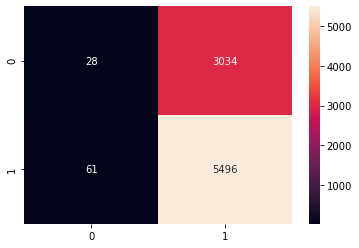

In [38]:
lr = LogisticRegression(solver='lbfgs', penalty ='l2')
lr.fit(scaledX, Y_train)
lr.score(X_test, Y_test)

y_pred = lr.predict(X_test)
ac = accuracy_score(Y_test,y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");
print(classification_report(Y_test, y_pred))


In [39]:
# declare variable
seed = 7
scoring = 'accuracy'

In [40]:
models = []
models.append(('DTC', DecisionTreeClassifier()))
models.append(('LGR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('NB', GaussianNB()))
models.append(('RDF', RandomForestClassifier()))


In [41]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
  cv_results = cross_val_score(model, X_train, Y_train, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

DTC: 0.548400 (0.007275)
LGR: 0.645607 (0.000351)
NB: 0.579324 (0.047223)
RDF: 0.612479 (0.003289)


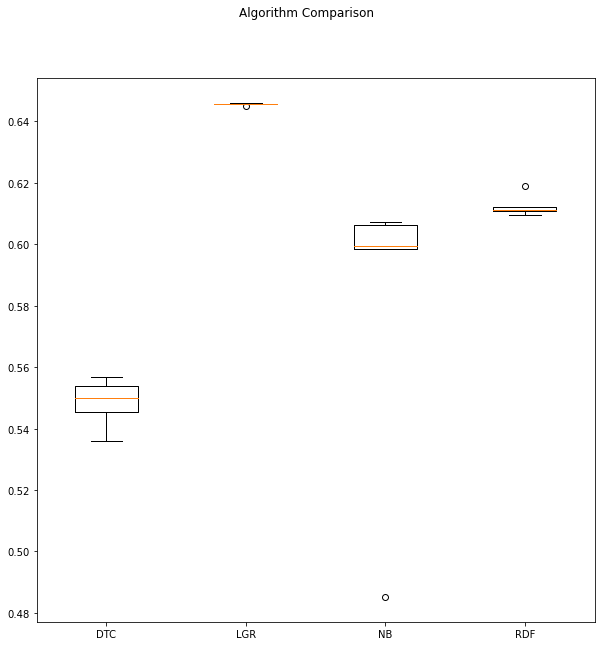

In [42]:
fig = pyplot.figure(figsize=(10, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [43]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledDTC', Pipeline([('Scaler', StandardScaler()),('DTC', DecisionTreeClassifier())])))
pipelines.append(('ScaledLGR', Pipeline([('Scaler', StandardScaler()),('LGR', LogisticRegression(solver='liblinear', multi_class='ovr'))])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledRDF', Pipeline([('Scaler', StandardScaler()),('RDF', RandomForestClassifier())])))


results = []
names = []
for name, model in pipelines:
  cv_results = cross_val_score(model, X_train, Y_train, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledDTC: 0.545992 (0.006037)
ScaledLGR: 0.645607 (0.000351)
ScaledNB: 0.579266 (0.047339)
ScaledRDF: 0.613292 (0.002838)


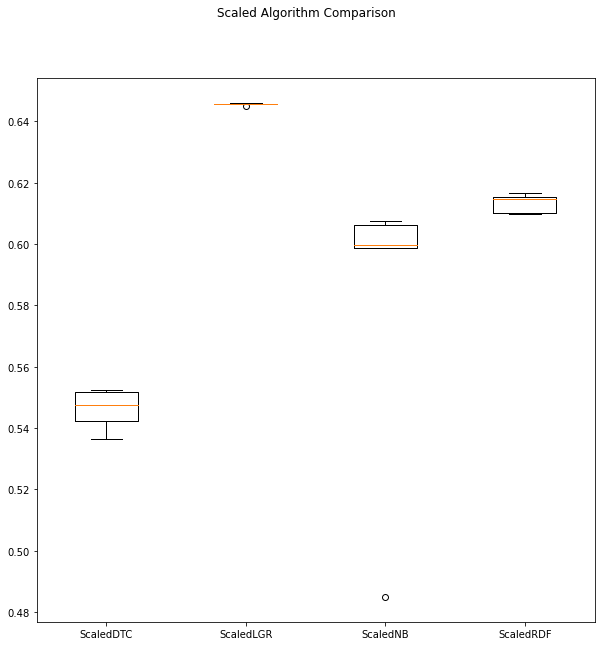

In [44]:
# Compare Algorithms
fig = pyplot.figure(figsize=(10, 10))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [45]:
# ensembles
ensembles = []
# boosting
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostClassifier())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier())])))
# bagging
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET',ExtraTreesClassifier())])))
results = []
names = []
for name, model in ensembles:
  cv_results = cross_val_score(model, X_train, Y_train, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledAB: 0.645636 (0.000420)
ScaledGBM: 0.645607 (0.000545)
ScaledET: 0.607519 (0.004749)


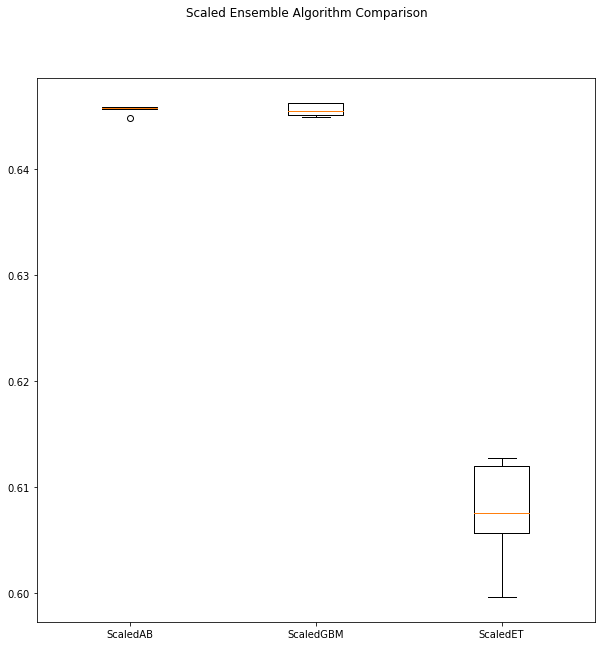

In [46]:
fig = pyplot.figure(figsize=(10, 10))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
# Scaled RandomForestClassifier
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=numpy.array([100,300,500,700,900]))
model = RandomForestClassifier(random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = RandomForestClassifier(random_state=seed, n_estimators=700)
model.fit(rescaledX, Y_train)

In [47]:
rescaledX = scaler.fit_transform(X_test)
predictions = model.predict(rescaledX)
print("Classification_report")
print(classification_report(Y_test, predictions))
print("Confusion matrix: ")
print(confusion_matrix(Y_test, predictions))


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:

sns.heatmap(confusion_matrix(Y_test, predictions),annot=True,fmt="d");


**GOOD RESULT!!!**

#**6. CONCLUSION**

- Through this project, we can know the main factors affecting satisfaction, thereby making reasonable adjustments to increase business efficiency.
- Sometimes retaining some features with a low correlation coefficient compared to the output results in better model results.